# Eager Execution

In [3]:
import tensorflow as tf

tf.__version__

'2.0.0-beta1'

In [4]:
c = tf.Variable([[1, 2], [3, 4]])
c


<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

In [5]:
c.numpy()  # 转换为numpy

array([[1, 2],
       [3, 4]])

In [6]:
w = tf.Variable([[1.0]])  # 新建张量

with tf.GradientTape() as tape:  # 追踪梯度
    loss = w * w

grad = tape.gradient(loss, w)  # 计算梯度
grad

<tf.Tensor: id=36, shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

# TensorFlow 2 实现线性回归

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

$$
f(w, b, x) = w*x + b
$$

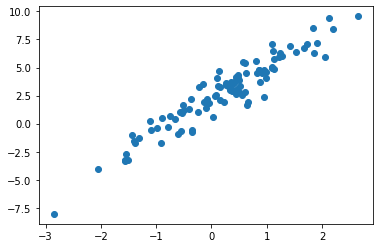

In [8]:
# y = 3*x + 2.0 +noise
TRUE_W = 3.0
TRUE_b = 2.0
NUM_SAMPLES = 100

# 初始化随机数据
X = tf.random.normal(shape=[NUM_SAMPLES, 1]).numpy()
noise = tf.random.normal(shape=[NUM_SAMPLES, 1]).numpy()
y = X * TRUE_W + TRUE_b + noise 
plt.scatter(X,y)

In [9]:
# 自定义模型
class Model(object):
    def __init__(self):
        # 随机初始化参数
        self.W = tf.Variable(tf.random.uniform([1]))
        self.b = tf.Variable(tf.random.uniform([1]))
        
    def __call__(self, x):
        return self.W * x + self.b  # 

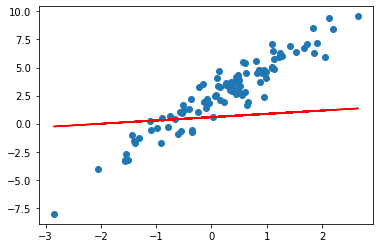

In [10]:
model = Model()

plt.scatter(X, y)
plt.plot(X, model(X), c='r')

直线没有拟合样本，于是定义损失函数去调整
$$
{\rm Loss}(w, b, x, y) = \sum_{i=1}^N (f(w, b, x_i) - y_i)^2
$$

In [11]:
def loss_fn(model, x, y):
    y_ = model(x)
    return tf.reduce_mean(tf.square(y_ - y))

**梯度下降的方法求解**

In [12]:
EPOCHS = 10
LEARNING_RATE = 0.1

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:   # 追踪梯度
        loss = loss_fn(model, X, y)
    dW, db = tape.gradient(loss, [model.W, model.b])
    model.W.assign_sub(LEARNING_RATE * dW)
    model.b.assign_sub(LEARNING_RATE * db)  # 更新梯度
    print('Epoch [{}/{}], loss [{:.3f}], W/b [{:.3f}/{:.3f}]'.format(epoch, EPOCHS, loss,
                                                                     float(model.W.numpy()),
                                                                     float(model.b.numpy())))

Epoch [0/10], loss [12.542], W/b [0.922/1.016]
Epoch [1/10], loss [7.418], W/b [1.397/1.336]
Epoch [2/10], loss [4.559], W/b [1.756/1.568]
Epoch [3/10], loss [2.962], W/b [2.027/1.737]
Epoch [4/10], loss [2.069], W/b [2.233/1.860]
Epoch [5/10], loss [1.568], W/b [2.389/1.948]
Epoch [6/10], loss [1.287], W/b [2.507/2.011]
Epoch [7/10], loss [1.129], W/b [2.598/2.055]
Epoch [8/10], loss [1.040], W/b [2.667/2.087]
Epoch [9/10], loss [0.989], W/b [2.720/2.109]


上面的代码中，我们初始化 tf.GradientTape() 以追踪梯度，然后使用 tape.gradient 方法就可以计算梯度了。值得注意的是，tape.gradient() 第二个参数支持以列表形式传入多个参数同时计算梯度。紧接着，使用 .assign_sub 即可完成公式中的减法操作用以更新梯度。

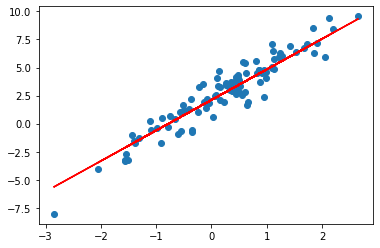

In [13]:
plt.scatter(X,y)
plt.plot(X, model(X), c='r')

**可以看出，迭代次数调到100次时，接近于我们设定的参数**

# 高阶API 实现
TensorFlow 2 中提供了大量的高阶 API 帮助我们快速构建所需模型，接下来，我们使用一些新的 API 来完成线性回归模型的构建。这里还是沿用上面提供的示例数据。

tf.keras 模块下提供的 tf.keras.layers.Dense 全连接层（线性层）实际上就是一个线性计算过程。所以，模型的定义部分我们就可以直接实例化一个全连接层即可。

In [34]:
# 为避免冲突，不同名字
m = tf.keras.layers.Dense(units=1)  # 实例化线性层,units 为输出空间维度，一维
m

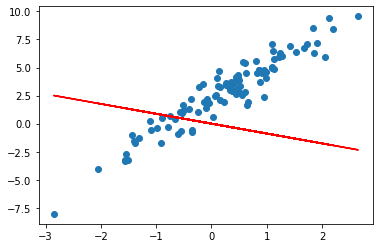

In [28]:
plt.scatter(X, y)
plt.plot(X, m(X), c='r')

In [17]:
model1.variables

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.6668123]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [29]:
EPOCHS = 10
LEARNING_RATE = 0.002
for epoch in range(EPOCHS):  # 迭代次数
    with tf.GradientTape() as tape:  # 追踪梯度
        y_ = m(X)
        loss = tf.reduce_sum(tf.keras.losses.mean_squared_error(y, y_))  # 计算损失

    grads = tape.gradient(loss, m.variables)  # 计算梯度
    optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)  # 随机梯度下降
    optimizer.apply_gradients(zip(grads, m.variables))  # 更新梯度

    print('Epoch [{}/{}], loss [{:.3f}]'.format(epoch, EPOCHS, loss))

Epoch [0/10], loss [2457.603]
Epoch [1/10], loss [677.181]
Epoch [2/10], loss [239.905]
Epoch [3/10], loss [130.830]
Epoch [4/10], loss [102.849]
Epoch [5/10], loss [95.322]
Epoch [6/10], loss [93.143]
Epoch [7/10], loss [92.448]
Epoch [8/10], loss [92.201]
Epoch [9/10], loss [92.104]


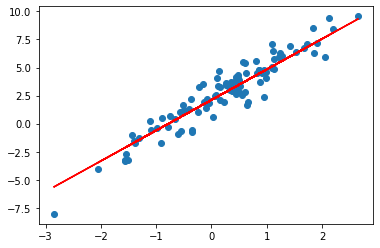

In [30]:
plt.scatter(X, y)
plt.plot(X, model(X), c='r')

# Keras 方式实现
Keras 提供的 Sequential 序贯模型结构。和上面的例子相似，向其中添加一个线性层。不同的地方在于，Keras 序贯模型第一层为线性层时，规定需指定输入维度，这里为 input_dim=1。

In [32]:
mm = tf.keras.Sequential()
mm.add(tf.keras.layers.Dense(units=1, input_dim=1))
mm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


接下来，直接使用 .compile 编译模型，指定损失函数为 MSE 平方损失，优化器选择 SGD 随机梯度下降。然后，就可以使用 .fit 传入数据开始迭代了。

In [35]:
mm.compile(optimizer='sgd', loss='mse')
mm.fit(X, y, steps_per_epoch=100)

Train on 100 samples
100/100 [==============================] - 0s 2ms/step - loss: 2.5461


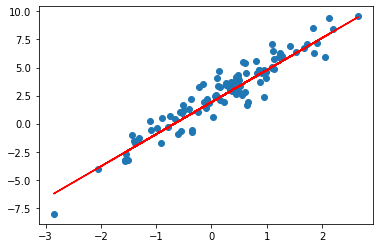

In [36]:
plt.scatter(X, y)
plt.plot(X, mm(X), c='r')